Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
# Import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import category_encoders as ce

In [4]:
# train/validation split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
train.describe(include = 'number')
# construction year of zero doesn't make sense
# Nor does latitude/longitude of zero.
# population of zero is potentially meaningful, it's possible a region with a pump has no one in it

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37037.915699,321.925261,669.567656,34.082431,-5.705946e+00,0.477736,15.258291,5.616751,179.805513,1302.768939
std,21412.099719,3197.240487,693.005745,6.552053,2.941332e+00,13.312977,17.530228,9.621230,463.081564,950.955437
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18482.750000,0.000000,0.000000,33.092142,-8.528215e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36986.500000,0.000000,372.500000,34.910740,-5.021436e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55450.250000,25.000000,1320.000000,37.170578,-3.327185e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [7]:
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,24988,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,2,1,12,2563,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,548,31071,21448,21448,21448,32449,42027,20287,20287,40598,40598,26567,26567,13620,13620,36638,22778,27642,25807


In [8]:
train[['waterpoint_type','waterpoint_type_group','source_class']].head(10)

,waterpoint_type,waterpoint_type_group,source_class
43360,communal standpipe,communal standpipe,groundwater
7263,communal standpipe,communal standpipe,groundwater
2486,hand pump,hand pump,groundwater
313,other,other,groundwater
52726,communal standpipe,communal standpipe,groundwater
8558,communal standpipe,communal standpipe,surface
2559,communal standpipe multiple,communal standpipe,groundwater
54735,communal standpipe,communal standpipe,groundwater
25763,hand pump,hand pump,groundwater
44540,other,other,groundwater


In [9]:
def wrangler(X):
    
    # Make a copy to avoid warning, prevent making changes from view.
    X = X.copy()
    
    # Replace near-zero latitudes with zero
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Replace near-zero longitudes with zero
    X['longitude'] = X['longitude'].replace(-2e-08, 0)
    
    # Swap zeros with nulls
    cols_with_zeros = ['longitude', 'latitude','construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # All the following are duplicate drops
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # extraction_type is a more specific version of extraction_type_group/class
    X = X.drop(columns=['extraction_type_group','extraction_type_class'])
    
    # Same for management and management_group
    X = X.drop(columns = 'management_group')
    
    # And payment / payment_type
    X = X.drop(columns = 'payment')
    
    # And water_quality/quality_group
    X = X.drop(columns = 'quality_group')
    
    # And water_quality/quality_group
    X = X.drop(columns = 'waterpoint_type_group')
    
    # Feature creation
    # create a 'distance from Dodoma' feature
    X['dodomadistance'] = (((X['latitude']-(6.1630))**2)+((X['longitude']-(35.7516))**2))**0.5
    
    # create a pump age feature
    X['pump_age'] = 2013 - X['construction_year']
    
    # create 'year_recorded' - year from date_recorded
    X['year_recorded'] = pd.to_datetime(X.date_recorded).dt.year
    
    # create 'structspect_interval' - number of years between construction and date recorded
    X['structspect_interval'] = X['year_recorded'] - X['construction_year']
    
    # return the wrangled dataframe
    return X

In [10]:
# Wrangle all datasets
train = wrangler(train)
val = wrangler(val)
test = wrangler(test)

In [11]:
# Define target
target = 'status_group'

# Frame without target and id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the number of unique classes for each categorical variable
catswithcounts = train_features.select_dtypes(exclude='number').nunique()

# set upper bound on class count
categorical_features = catswithcounts[catswithcounts <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange train/val/test data
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# map Ys to integers for the encoder
mapdict = {
    'functional': 1,
    'non functional': -1,
    'functional needs repair': 0
}
y_train_mapped = y_train.map(mapdict)
y_val_mapped = y_val.map(mapdict)

In [28]:
# Make decision tree pipeline

thelorax = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=38, min_samples_leaf=1, random_state=42)
)

In [29]:
# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.9950126262626262
validation accuracy:  0.752104377104377


In [14]:
# Grab my gradient descent code, use it for tree depth and leaf samples
# tree length first

treemin = 1
treemax = 50
bounddict = {
    'lowbound': treemin,
    'midbound': int(round((treemin+treemax)/2)),
    'upbound': treemax
}

for i in range(1,10):
    boundaccuracy={}
    # Set the central value according to the bounds
    bounddict['midbound'] = int(round((bounddict['lowbound']+bounddict['upbound'])/2))
    for key,value in bounddict.items():
        # Make decision tree pipeline with the bound we're testing

        thelorax = make_pipeline(
            ce.OneHotEncoder(use_cat_names=True),
            SimpleImputer(),
            StandardScaler(),
            DecisionTreeClassifier(max_depth=value, min_samples_leaf=1, random_state=42)
            )
        
        # Fit the model, score it
        thelorax.fit(X_train,y_train)
        print ('train accuracy: ', thelorax.score(X_train, y_train))
        print ('validation accuracy: ', thelorax.score(X_val, y_val))
        
        # Get the error for the value
        boundaccuracy[key] = thelorax.score(X_val, y_val)
    #Eliminate whichever extremal bound is worse
    if boundaccuracy['lowbound'] < boundaccuracy['upbound']:
        bounddict['lowbound'] = bounddict['midbound']
    else:
        bounddict['upbound'] = bounddict['midbound']

train accuracy:  0.6405934343434343
validation accuracy:  0.6492424242424243
train accuracy:  0.9651304713804714
validation accuracy:  0.756986531986532
train accuracy:  0.9958333333333333
validation accuracy:  0.753030303030303
train accuracy:  0.9651304713804714
validation accuracy:  0.756986531986532
train accuracy:  0.9950126262626262
validation accuracy:  0.752104377104377
train accuracy:  0.9958333333333333
validation accuracy:  0.753030303030303
train accuracy:  0.9651304713804714
validation accuracy:  0.756986531986532
train accuracy:  0.9894149831649832
validation accuracy:  0.7540404040404041
train accuracy:  0.9950126262626262
validation accuracy:  0.752104377104377
train accuracy:  0.9651304713804714
validation accuracy:  0.756986531986532
train accuracy:  0.9809343434343434
validation accuracy:  0.7553872053872054
train accuracy:  0.9894149831649832
validation accuracy:  0.7540404040404041
train accuracy:  0.9651304713804714
validation accuracy:  0.756986531986532
train ac

In [15]:
bounddict

{'lowbound': 28, 'midbound': 28, 'upbound': 28}

In [17]:
# Checking whether 26 or 27 produced the better value

thelorax = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=28, min_samples_leaf=1, random_state=42)
)

# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.9764941077441077
validation accuracy:  0.7580808080808081


In [18]:
# Grab my gradient descent code, use it for tree depth and leaf samples
# now leaves

leafmin = 1
leafmax = 100
bounddict = {
    'lowbound': leafmin,
    'midbound': int(round((leafmin+leafmax)/2)),
    'upbound': leafmax
}

for i in range(1,10):
    boundaccuracy={}
    # Set the central value according to the bounds
    bounddict['midbound'] = int(round((bounddict['lowbound']+bounddict['upbound'])/2))
    for key,value in bounddict.items():
        # Make decision tree pipeline with the bound we're testing

        thelorax = make_pipeline(
            ce.OneHotEncoder(use_cat_names=True),
            SimpleImputer(),
            StandardScaler(),
            DecisionTreeClassifier(max_depth=28, min_samples_leaf=value, random_state=42)
            )
        
        # Fit the model, score it
        thelorax.fit(X_train,y_train)
        print ('train accuracy: ', thelorax.score(X_train, y_train))
        print ('validation accuracy: ', thelorax.score(X_val, y_val))
        
        # Get the error for the value
        boundaccuracy[key] = thelorax.score(X_val, y_val)
    #Eliminate whichever extremal bound is worse
    if boundaccuracy['lowbound'] < boundaccuracy['upbound']:
        bounddict['lowbound'] = bounddict['midbound']
    else:
        bounddict['upbound'] = bounddict['midbound']

train accuracy:  0.9764941077441077
validation accuracy:  0.7580808080808081
train accuracy:  0.7771885521885522
validation accuracy:  0.7609427609427609
train accuracy:  0.7598695286195286
validation accuracy:  0.7523569023569023
train accuracy:  0.9764941077441077
validation accuracy:  0.7580808080808081
train accuracy:  0.7984638047138047
validation accuracy:  0.7693602693602694
train accuracy:  0.7771885521885522
validation accuracy:  0.7609427609427609
train accuracy:  0.7984638047138047
validation accuracy:  0.7693602693602694
train accuracy:  0.7861321548821549
validation accuracy:  0.7618686868686869
train accuracy:  0.7771885521885522
validation accuracy:  0.7609427609427609
train accuracy:  0.7984638047138047
validation accuracy:  0.7693602693602694
train accuracy:  0.7913930976430976
validation accuracy:  0.7656565656565657
train accuracy:  0.7861321548821549
validation accuracy:  0.7618686868686869
train accuracy:  0.7984638047138047
validation accuracy:  0.7693602693602694

In [24]:
bounddict

{'lowbound': 26, 'midbound': 26, 'upbound': 26}

In [23]:
# Checking whether 17 or 18 produced the better value

thelorax = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=28, min_samples_leaf=17, random_state=42)
)

# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.8152356902356902
validation accuracy:  0.7712121212121212


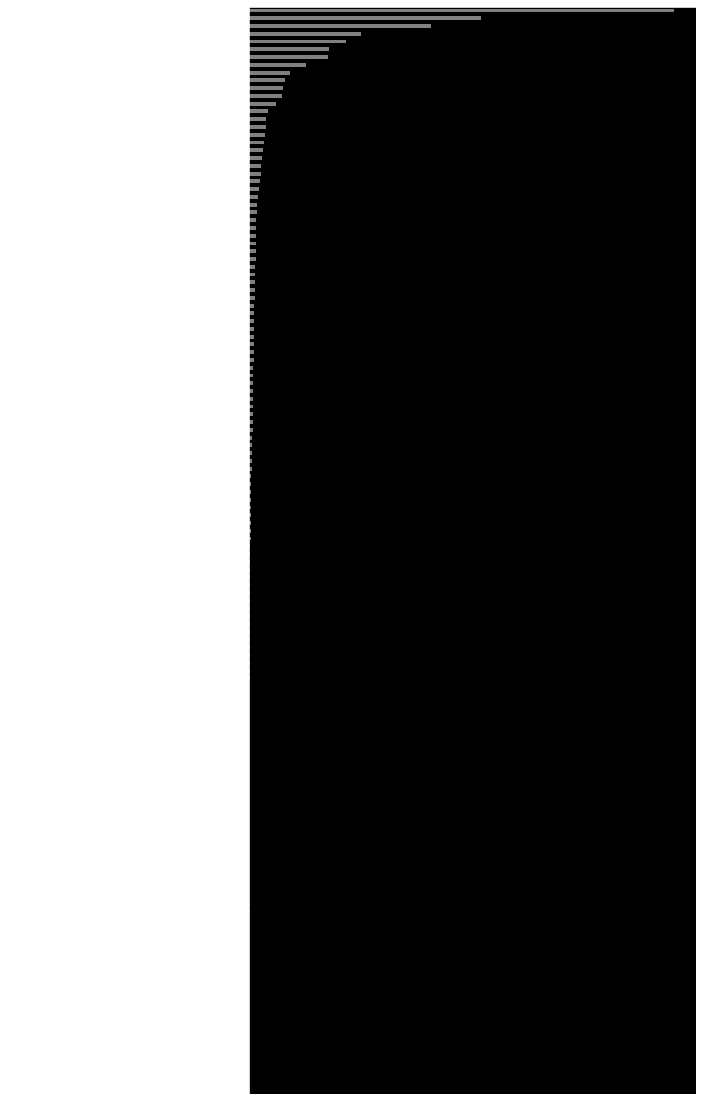

In [25]:
# feature importances

model = thelorax.named_steps['decisiontreeclassifier']
encoder = thelorax.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey', figsize = [8,20])

In [ ]:
# Predicting test data

y_test_pred = thelorax.predict(X_test)

In [ ]:
# Formatting submission
submission = sample_submission.copy()
submission['status_group'] = y_test_pred
submission.to_csv('submission-03.csv', index = False)